# 1 - Preliminaries

In [48]:
import copy
import itertools
from collections import defaultdict
from operator import itemgetter

#### Our dataset format
An event is a string. At each time instant, there may be several events, which is called an eventset.

An eventset is a list of events.

A sequence is a list of eventsets.

A dataset is a list of sequences.

Thus, a dataset is a list of lists of lists of strings.

In [49]:
dataset =  [
    [["a"], ["a", "b", "c"], ["a", "c"], ["c"]],
    [["a"], ["c"], ["b", "c"]],
    [["a", "b"], ["d"], ["c"], ["b"], ["c"]],
    [["a"], ["c"], ["b"], ["c"]]
]

# 2- Foundations
### Subsequences

In [50]:
"""
This is a simple recursive method that checks if subsequence is a subSequence of mainSequence
"""
def isSubsequence(mainSequence, subSequence):
    subSequenceClone = list(subSequence) # clone the sequence, because we will alter it
    return isSubsequenceRecursive(mainSequence, subSequenceClone) #start recursion

"""
Function for the recursive call of isSubsequence, not intended for external calls
"""
def isSubsequenceRecursive(mainSequence, subSequenceClone, start=0):
    # Check if empty: End of recursion, all eventsets have been found
    if (not subSequenceClone):
        return True
    # retrieves element of the subsequence and removes is from subsequence 
    firstElem = set(subSequenceClone.pop(0))
    # Search for the first eventset...
    for i in range(start, len(mainSequence)):
        if (set(mainSequence[i]).issuperset(firstElem)):
            # and recurse
            return isSubsequenceRecursive(mainSequence, subSequenceClone, i + 1)
    return False

In [51]:
aSequence = [["a"], ["b", "c"], ["d"], ["a", "e"]]

In [52]:
isSubsequence(aSequence, [["a"], ["d"], ["e"]])

True

In [53]:
isSubsequence(aSequence, [["a"], ["b", "c"], ["e"]])

True

In [54]:
isSubsequence(aSequence, [["a"], ["b", "d"]])

False

### Length of an eventset

In [55]:
"""
Computes the length of the pattern (subsequence) (sum of the length of the contained eventsets)
"""
def sequenceLength(sequence):
    return sum(len(i) for i in sequence)

In [56]:
print(sequenceLength ([["a"], ["b", "c"], ["a"], ["b","c","d"]]))

7


### Support of a pattern

In [57]:
"""
Computes the support of a pattern (subsequence) in a dataset
"""
def countSupport (dataset, candidateSequence):
    return sum(1 for seq in dataset if isSubsequence(seq, candidateSequence)) 

In [58]:
dataset

[[['a'], ['a', 'b', 'c'], ['a', 'c'], ['c']],
 [['a'], ['c'], ['b', 'c']],
 [['a', 'b'], ['d'], ['c'], ['b'], ['c']],
 [['a'], ['c'], ['b'], ['c']]]

In [59]:
countSupport(dataset, [["b"]])

4

In [60]:
countSupport(dataset, [["a"], ["b", "c"]])

2

# 3- PrefixSpan algorithm

### Project a sequence

In [61]:
"""
Projects a sequence according to a given prefix, as done in PrefixSpan

Args:
    sequence: the sequence the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first eventset is ignored
Returns:
    x, then None.If the sequence does not contain the prefi
    Otherwise, a new sequence starting from the position of the prefix, including the eventset that includes the prefix
"""
def projectSequence(sequence, prefix, newEvent):
    result = None
    for i, eventset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in eventset for x in prefix)):
                    result = [list(eventset)]
        else:
            result.append(copy.copy(eventset))
    return result

In [62]:
seq = [["a"], ["b", "c"], ["a", "c"], ["c"]]
projectSequence(seq, ["b"], False)

[['b', 'c'], ['a', 'c'], ['c']]

In [63]:
projectSequence(seq, ["a", "c"], False)

[['a', 'c'], ['c']]

In [64]:
projectSequence(seq, ["a"], False)

[['a'], ['b', 'c'], ['a', 'c'], ['c']]

In [65]:
projectSequence(seq, ["a"], True)

[['a', 'c'], ['c']]

### Project a dataset

In [66]:
"""
Projects a dataset according to a given prefix, as done in PrefixSpan

Args:
    dataset: the dataset the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first eventset is ignored
Returns:
    A (potentially empty) list of sequences
"""
def projectDatabase(dataset, prefix, newEvent):
    projectedDB = []
    for sequence in dataset:
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

In [67]:
datasetProject = [
            [["a"], ["a", "b", "c"], ["a", "c"], ["d"], ["c", "f"]],
            [["a", "d"], ["c"], ["b", "c"], ["a", "e"]],
            [["e", "f"], ["a", "b"], ["d", "f"], ["d"], ["b"]],
            [["e"], ["g"], ["a", "f"], ["c"], ["b"], ["c"]]
        ]

In [68]:
projectDatabase(datasetProject, ["c"], False)

[[['a', 'b', 'c'], ['a', 'c'], ['d'], ['c', 'f']],
 [['c'], ['b', 'c'], ['a', 'e']],
 [['c'], ['b'], ['c']]]

### The main algorithm

#### Some more utility functions:

In [69]:
"""
Generates a list of all items that are contained in a dataset
"""
def generateItems(dataset):
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

"""
Computes a defaultdict that maps each item in the dataset to its support
"""
def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for eventset in sequence:
            if all(x in eventset for x in prefix):
                for item in eventset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

#### Finally, the algorithm:

In [70]:
"""
The PrefixSpan algorithm. Computes the frequent patterns in a sequence dataset for a given minFrequency

Args:
    dataset: A list of sequences, for which the frequent (sub-)sequences are computed
    minFrequency: The minimum support that makes a pattern (subsequence) frequent
Returns:
    A list of tuples (s, c), where s is a frequent pattern, and c is the count for that pattern
"""
def prefixSpan(dataset, minFrequency):
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in itemCounts:
        if count >= minFrequency:
            newPrefix = [item]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minFrequency, newPrefix))
    return result

def prefixSpanInternal(dataset, minFrequency, prevPrefixes=[]):
    result = []
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minFrequency:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minFrequency, newPrefix))
    return result

In [71]:
prefixSpan(dataset, 2)

[(['a'], 4),
 (['a', 'b'], 4),
 (['a', 'b', 'c'], 3),
 (['a', 'c'], 4),
 (['a', 'c', 'b'], 3),
 (['a', 'c', 'b', 'c'], 2),
 (['a', 'c', 'c'], 4),
 (['b'], 4),
 (['b', 'c'], 3),
 (['b', 'c', 'c'], 2),
 (['c'], 4),
 (['c', 'b'], 3),
 (['c', 'b', 'c'], 2),
 (['c', 'c'], 4)]

# 4- Practical work: analyzing YahooFinance data
Now we try to find some episodes in a real world data sequence.

First, load the dataset.

In [72]:
import csv

def loadYahooDataset():
    currentLineNumber=0
    idSeq='1'
    newEventSet=[]
    yahooDataset=[]
    for line in csv.reader((row for row in open("K:\\Data science\\Text mining\\Autonomous Work\\YahooFinance.data")), delimiter='\t'):
        currentLineNumber+=1
        if currentLineNumber==1:  # header line
            continue
        if line[1] != idSeq:
            yahooDataset.append(newEventSet)
            idSeq=line[1]
            newEventSet=[]
        if not line[2].endswith('0'):
            newEventSet.append(line[2])
    yahooDataset.append(newEventSet)
    return yahooDataset

In [73]:
yahooDataset=loadYahooDataset()
yahooDataset

[['Microsoft=3',
  'Citigroup=3',
  'Exxon_Mobil=-2',
  'HP=3',
  'Coca_Cola=-1',
  'General_Motors=3',
  'Intel=3',
  'Altria=-3',
  'American_Express=3',
  'AT&T=1',
  'Procter_&_Gamble=-2',
  'Verizon=3',
  'Morgan_Chase=3'],
 ['Microsoft=1',
  'Boeing=-1',
  'Citigroup=1',
  'Du_Pont=1',
  'Exxon_Mobil=-1',
  'HP=1',
  'Coca_Cola=-1',
  'General_Motors=2',
  'Intel=-1',
  'Altria=-2',
  'American_Express=-2',
  'AT&T=1',
  'Procter_&_Gamble=-2',
  'Verizon=1',
  'Morgan_Chase=1'],
 ['Microsoft=1',
  'Boeing=-2',
  'Citigroup=-2',
  'Du_Pont=-1',
  'HP=-3',
  'General_Motors=-3',
  'Intel=-3',
  'American_Express=-2',
  'AT&T=-2',
  'Procter_&_Gamble=2',
  'Morgan_Chase=-3'],
 ['HP=1',
  'Coca_Cola=1',
  'General_Motors=-1',
  'Altria=2',
  'American_Express=-3',
  'Procter_&_Gamble=1'],
 ['Microsoft=3',
  'Citigroup=-1',
  'Du_Pont=-2',
  'Exxon_Mobil=-1',
  'Coca_Cola=1',
  'General_Motors=2',
  'Altria=2',
  'American_Express=-2',
  'AT&T=2',
  'Procter_&_Gamble=-1',
  'Verizon=1

## About dataset
There are 3 rows and 18824 colums in dataset, where colums are (id_sequence, id_time and coation), in the coation, the events are given with different frequency.

# Question 1: Creating function for Windows

In [74]:
def windowization(dataset, max_span):
    get = []    
    for i in range(len(dataset)-(max_span)):  
        window = []
        for j in range(i, i+max_span+1):
            window.append(dataset[j])
        get.append(window)
    return get
Windows=windowization(yahooDataset, 2)
Windows

[[['Microsoft=3',
   'Citigroup=3',
   'Exxon_Mobil=-2',
   'HP=3',
   'Coca_Cola=-1',
   'General_Motors=3',
   'Intel=3',
   'Altria=-3',
   'American_Express=3',
   'AT&T=1',
   'Procter_&_Gamble=-2',
   'Verizon=3',
   'Morgan_Chase=3'],
  ['Microsoft=1',
   'Boeing=-1',
   'Citigroup=1',
   'Du_Pont=1',
   'Exxon_Mobil=-1',
   'HP=1',
   'Coca_Cola=-1',
   'General_Motors=2',
   'Intel=-1',
   'Altria=-2',
   'American_Express=-2',
   'AT&T=1',
   'Procter_&_Gamble=-2',
   'Verizon=1',
   'Morgan_Chase=1'],
  ['Microsoft=1',
   'Boeing=-2',
   'Citigroup=-2',
   'Du_Pont=-1',
   'HP=-3',
   'General_Motors=-3',
   'Intel=-3',
   'American_Express=-2',
   'AT&T=-2',
   'Procter_&_Gamble=2',
   'Morgan_Chase=-3']],
 [['Microsoft=1',
   'Boeing=-1',
   'Citigroup=1',
   'Du_Pont=1',
   'Exxon_Mobil=-1',
   'HP=1',
   'Coca_Cola=-1',
   'General_Motors=2',
   'Intel=-1',
   'Altria=-2',
   'American_Express=-2',
   'AT&T=1',
   'Procter_&_Gamble=-2',
   'Verizon=1',
   'Morgan_Chase=1

#### Concept of this function, we have create function for window and after we applied for loop for select all data set and after we have subtract with maxspan. in the same for loop we have create another for loop (j) were this loop increce maxspan, after we have set the lenght 2. 

# Question 2: Apply PrefixSpan Algorithm

In [75]:
# set minumum frequency
minFrequency = 20

# Calling prefixSpan function
ps = prefixSpan(Windows, minFrequency)
ps

[(['AT&T=-1'], 567),
 (['AT&T=-1', 'AT&T=-1'], 108),
 (['AT&T=-1', 'AT&T=-2'], 31),
 (['AT&T=-1', 'AT&T=1'], 108),
 (['AT&T=-1', 'AT&T=2'], 30),
 (['AT&T=-1', 'Altria=-1'], 99),
 (['AT&T=-1', 'Altria=-2'], 26),
 (['AT&T=-1', 'Altria=1'], 132),
 (['AT&T=-1', 'Altria=2'], 24),
 (['AT&T=-1', 'American_Express=-1'], 130),
 (['AT&T=-1', 'American_Express=-1', 'Exxon_Mobil=1'], 21),
 (['AT&T=-1', 'American_Express=1'], 118),
 (['AT&T=-1', 'American_Express=2'], 40),
 (['AT&T=-1', 'Boeing=-1'], 131),
 (['AT&T=-1', 'Boeing=-2'], 31),
 (['AT&T=-1', 'Boeing=1'], 144),
 (['AT&T=-1', 'Boeing=2'], 29),
 (['AT&T=-1', 'Citigroup=-1'], 117),
 (['AT&T=-1', 'Citigroup=1'], 120),
 (['AT&T=-1', 'Citigroup=2'], 23),
 (['AT&T=-1', 'Citigroup=3'], 21),
 (['AT&T=-1', 'Coca_Cola=-1'], 104),
 (['AT&T=-1', 'Coca_Cola=1'], 105),
 (['AT&T=-1', 'Du_Pont=-1'], 111),
 (['AT&T=-1', 'Du_Pont=1'], 124),
 (['AT&T=-1', 'Du_Pont=2'], 27),
 (['AT&T=-1', 'Exxon_Mobil=-1'], 109),
 (['AT&T=-1', 'Exxon_Mobil=1'], 151),
 (['AT&T

#### We have set the minimum frequency 20 and prefixSpan algorithm has already implented in the above section, we have call prefixSpan function in our expirement, where we stored in PS variable. The output shown as patterns, length of patterns and frequency of patterns.

# Question 3: Computing most 5 frequent patterns of length 2 and  length 3

In [76]:
# Store the output in Pandas DataFrame
import pandas as pd
df = pd.DataFrame(ps, columns = ["Patterns", "Patterns Frequency"])    
df["Patterns Lenth"] = [len(x) for x,y in ps]    
df.head(5)

,Patterns,Patterns Frequency,Patterns Lenth
0,[AT&T=-1],567,1
1,"[AT&T=-1, AT&T=-1]",108,2
2,"[AT&T=-1, AT&T=-2]",31,2
3,"[AT&T=-1, AT&T=1]",108,2
4,"[AT&T=-1, AT&T=2]",30,2


#### We have store output in pandas datafram for shorting in easy way, where we select the columns (Patterns, Patterns Frequency and Patterns Lenth)

### Most 5 frequent patterns of length 2 

In [77]:
# DataFrame sorted by the 5 largest values of lenght 2.
DF=df.loc[df["Patterns Lenth"] == 2] 
DF.nlargest(5, "Patterns Frequency")

,Patterns,Patterns Frequency,Patterns Lenth
511,"[Boeing=-1, Boeing=1]",208,2
606,"[Boeing=1, Boeing=-1]",186,2
1267,"[General_Motors=-1, Exxon_Mobil=1]",181,2
612,"[Boeing=1, Boeing=1]",177,2
1250,"[General_Motors=-1, Boeing=1]",172,2


 #### We have used nlargest() method of pandas for sorting, where we have short most 5 frequent patterns of lenght 2 and similarly for lenght 3.

###  Most 5 frequent patterns of length 3 

In [78]:
# DataFrame sorted by the 5 largest values of lenght 3.
DF=df.loc[df["Patterns Lenth"] == 3] 
DF.nlargest(5, "Patterns Frequency")

,Patterns,Patterns Frequency,Patterns Lenth
608,"[Boeing=1, Boeing=-1, Boeing=1]",32,3
1128,"[Exxon_Mobil=-1, Boeing=-1, Boeing=1]",26,3
512,"[Boeing=-1, Boeing=1, Boeing=-1]",25,3
513,"[Boeing=-1, Boeing=1, General_Motors=1]",25,3
626,"[Boeing=1, Exxon_Mobil=-1, Boeing=1]",25,3


# Question 4: Creating function for set the temporal rules.

In [79]:
# Import necessary libraries
import math
from math import log2


# Creating function for temporal rules
def temporal_rule(List):
    df = pd.DataFrame(List, columns = ["Patterns", "Patterns Frequency"])
    df.index = df["Patterns"].astype(str)
    
    Lift = []
    Frequency= []
    J_Measure = []
    Confidance = []
    Recall = []
    X = []
    Y = []
    
    for i, j in List:
        if len(i) > 1:
            
            X.append(i[:-1])
            Y.append(i[-1])
            
            nX = df.loc[str(i[:-1]), "Patterns Frequency"]
            nY = df.loc[str(i[-1:]), "Patterns Frequency"]
            
            
            nXY = j
            Frequency.append(j/len(List))
            Confidance.append(j/nX)
            Recall.append(j/nY)
            Lift.append((nXY*len(List))/(nX*nY))            
            J_Measure.append((nX-nXY)/len(List)*log2((nX-nXY)*len(List)/(nX*(len(List)-nY)))+nXY/len(List)*log2(nXY*len(List)/(nX*nY)))
    DF2 = pd.DataFrame()
    DF2["temporal_rule(X->Y)"] = [str(X[K]).replace("','", " and ").replace("['", "").replace("']", "") + "->" + str(Y[K]) for K in range(len(X))]    
    DF2["X"] = X
    DF2["Y"] = Y
    DF2["Frequency"] = Frequency
    DF2["Confidence"] = Confidance 
    DF2["Recall"] = Recall
    DF2["Lift"] = Lift    
    DF2["J_Measure"] = J_Measure
    return DF2
Rules=temporal_rule(ps)
Rules

,temporal_rule(X->Y),X,Y,Frequency,Confidence,Recall,Lift,J_Measure
0,AT&T=-1->AT&T=-1,[AT&T=-1],AT&T=-1,0.042840,0.190476,0.190476,0.846897,1.147263e-03
1,AT&T=-1->AT&T=-2,[AT&T=-1],AT&T=-2,0.012297,0.054674,0.198718,0.883541,1.507354e-04
2,AT&T=-1->AT&T=1,[AT&T=-1],AT&T=1,0.042840,0.190476,0.193896,0.862101,9.061779e-04
3,AT&T=-1->AT&T=2,[AT&T=-1],AT&T=2,0.011900,0.052910,0.218978,0.973622,6.541511e-06
4,AT&T=-1->Altria=-1,[AT&T=-1],Altria=-1,0.039270,0.174603,0.221973,0.986939,5.969597e-06
5,AT&T=-1->Altria=-2,[AT&T=-1],Altria=-2,0.010313,0.045855,0.285714,1.270345,4.100247e-04
6,AT&T=-1->Altria=1,[AT&T=-1],Altria=1,0.052360,0.232804,0.229167,1.018923,1.712819e-05
7,AT&T=-1->Altria=2,[AT&T=-1],Altria=2,0.009520,0.042328,0.218182,0.970082,6.689574e-06
8,AT&T=-1->American_Express=-1,[AT&T=-1],American_Express=-1,0.051567,0.229277,0.230496,1.024835,2.867127e-05
9,"AT&T=-1', 'American_Express=-1->Exxon_Mobil=1","[AT&T=-1, American_Express=-1]",Exxon_Mobil=1,0.008330,0.161538,0.032159,0.623642,2.035418e-03


# Question 5:  Best rules of length 2 and  length 3 according to Lift.

In [80]:
# Apply sorting method according to Lift
Rules.sort_values(by=['Lift'], inplace=True, ascending=False)
Rules

,temporal_rule(X->Y),X,Y,Frequency,Confidence,Recall,Lift,J_Measure
2433,Verizon=2->Intel=-3,[Verizon=2],Intel=-3,0.008330,0.164062,0.176471,3.475643,0.006959
1700,Intel=-3->Intel=3,[Intel=-3],Intel=3,0.009123,0.193277,0.143750,3.045326,0.006461
472,American_Express=2->Verizon=-2,[American_Express=2],Verizon=-2,0.008330,0.122093,0.196262,2.876603,0.005194
1791,Intel=3->AT&T=2,[Intel=3],AT&T=2,0.009123,0.143750,0.167883,2.645210,0.005017
1973,Microsoft=2->Boeing=2,[Microsoft=2],Boeing=2,0.009520,0.149068,0.151899,2.378489,0.004319
1799,Intel=3->Boeing=2,[Intel=3],Boeing=2,0.009123,0.143750,0.145570,2.293631,0.003834
1437,HP=-2->Citigroup=-2,[HP=-2],Citigroup=-2,0.007933,0.092166,0.196078,2.277943,0.003178
447,American_Express=2->American_Express=-2,[American_Express=2],American_Express=-2,0.007933,0.116279,0.151515,2.220754,0.003057
468,American_Express=2->Morgan_Chase=-2,[American_Express=2],Morgan_Chase=-2,0.009123,0.133721,0.147436,2.160965,0.003349
1814,Intel=3->Intel=3,[Intel=3],Intel=3,0.008330,0.131250,0.131250,2.068008,0.002756


# Question 6: What to you think of the values of conﬁdence and recall? 

####  We have analysis the variables, confidence and recall have strong relation and values of both variables are corelated to each other. It means it will show tightly clustered along an imaginary line.

# Question 7: scatterplot matrix 

C:\Users\AZAZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214D73C8198>,
      dtype=object)

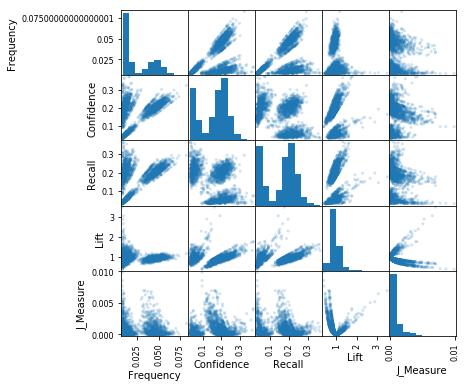

In [81]:
# Import necessary libraries
import numpy as np
from pandas.tools.plotting import scatter_matrix
import pandas as pd

# Apply pandas.plotting.scatter_matrix 
db = pd.DataFrame(Rules, columns=['Frequency','Confidence','Recall','Lift','J_Measure'])
scatter_matrix(db, alpha=0.2, figsize=(6, 6))


#### As we can see in the plot, digonal graph is showing Histogram of all varibales. They all are independent and all pairs of variables are positively correlated.The strongest relationship appears to be between confidence and recall and they all normally distributed. 
